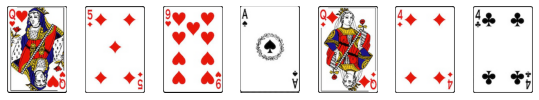

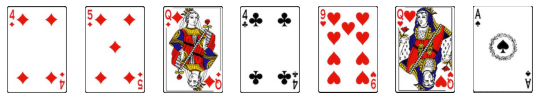

In [1]:
#!pip install pydealer
from hand2hand import Cards
import pydealer
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

deck = Cards()
pydeck = pydealer.Deck()
pydeck.shuffle()
hand = pydeck.deal(7)
deck.show_pyhand(hand)
deck.sort_pyhand(hand)
deck.show_pyhand(hand)


In [2]:
import tensorflow as tf
import seq2seq_transformer
from seq2seq_transformer import TokenAndPositionEmbedding, TokenEmbedding, TransformerBlock
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model

### Classify with an "Abstracter"

Classify with a transformer where Encoder-Decoder attention that uses Keys=E, Queries=E, Values=D, 
where E are encoder states and D are decoder states.


In [3]:
import tensorflow as tf
from seq2seq_transformer import Transformer, Encoder, Abstracter, EpisodicDecoder


In [4]:
class AbstractClassifier():
    def __init__(self, n, embed_dim=32, num_layers=4, num_heads=8, ff_dim1=128, ff_dim2=32):
        vocab_size=52
        self.embed_dim = embed_dim
        attr_input = layers.Input(shape=(n,))
        context = Encoder(num_layers=num_layers, d_model=embed_dim, num_heads=num_heads, 
                        dff=ff_dim1, vocab_size=vocab_size)(attr_input)
        
        cogstate = layers.Input(shape=(n,))
        x = EpisodicDecoder(num_layers=num_layers, d_model=embed_dim,
                            num_heads=num_heads, dff=ff_dim1,
                            vocab_size=n)(cogstate, context)

        model_out = layers.GlobalAveragePooling1D()(x)
        x = layers.Dense(ff_dim2, activation='relu')(model_out) 
        outputs = layers.Dense(2, activation='softmax')(x)
        
        self.model = Model(inputs=[attr_input, cogstate], outputs=outputs)
        self.model.summary()
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model_initial_weights = self.model.get_weights()

    def train(self, X_train, y_train):
        self.model.set_weights(self.model_initial_weights)
        self.model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=1)

    def predict(self, X_test):
        out = self.model.predict(X_test)
        return out

In [5]:
hac = AbstractClassifier(7, num_layers=3, num_heads=2)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 encoder (Encoder)              (None, 7, 32)        52352       ['input_1[0][0]']                
                                                                                                  
 episodic_decoder (EpisodicDeco  (None, 7, 32)       76352       ['input_2[0][0]',                
 der)                                                             'encoder[0][0]']            

In [6]:
n = 10000
hand_size = 7
X = np.zeros((n, hand_size), dtype=int)
y = np.zeros(n, dtype=int)

for i in np.arange(n):
    hand = pydeck.deal(hand_size)
    if len(hand) < hand_size:
        # ran out of cards, make a new deck
        pydeck = pydealer.Deck()
        pydeck.shuffle()
        hand = pydeck.deal(hand_size)
    if np.random.normal() < 0:
        deck.sort_pyhand(hand)
    X[i,:] = deck.index_pyhand(hand)
    y[i] = deck.is_sorted_pyhand(hand)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

init_state = np.zeros((X_train.shape[0], X_train.shape[1]), dtype=int)
for i in range(init_state.shape[1]):
    init_state[:,i]=i
Z_train = X_train, init_state

init_state = np.zeros((X_test.shape[0], X_test.shape[1]), dtype=int)
for i in range(init_state.shape[1]):
    init_state[:,i]=i
Z_test = X_test, init_state

In [8]:
hac.train(Z_train, y_train)

Epoch 1/10
59/59 [==============================] - 17s 48ms/step - loss: 0.6966 - accuracy: 0.5321
Epoch 2/10
59/59 [==============================] - 3s 58ms/step - loss: 0.1870 - accuracy: 0.9421
Epoch 3/10
59/59 [==============================] - 3s 47ms/step - loss: 0.0680 - accuracy: 0.9815
Epoch 4/10
59/59 [==============================] - 3s 55ms/step - loss: 0.0416 - accuracy: 0.9889
Epoch 5/10
59/59 [==============================] - 3s 49ms/step - loss: 0.0387 - accuracy: 0.9895
Epoch 6/10
59/59 [==============================] - 4s 60ms/step - loss: 0.0398 - accuracy: 0.9885
Epoch 7/10
59/59 [==============================] - 4s 62ms/step - loss: 0.0468 - accuracy: 0.9872
Epoch 8/10
59/59 [==============================] - 3s 54ms/step - loss: 0.0260 - accuracy: 0.9928
Epoch 9/10
59/59 [==============================] - 3s 54ms/step - loss: 0.0299 - accuracy: 0.9919
Epoch 10/10
59/59 [==============================] - 3s 54ms/step - loss: 0.0300 - accuracy: 0.9911


In [9]:
out = hac.predict(Z_test)
yhat_test = np.argmax(out, axis=1)
print('accuracy: %.2f%%' % (100*np.sum(yhat_test == y_test)/len(y_test)))

79/79 [==============================] - 2s 11ms/step
accuracy: 99.48%


Next step will be to repeat this with a CNN embedder for images.